In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
import matplotlib
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)

/Users/Future/Library/Python/3.6/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_to_save = "../results/Figures/Figure 5/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [3]:
train = sc.read("../data/train_species.h5ad")
train

AnnData object with n_obs × n_vars = 62114 × 6619 
    obs: 'condition', 'species', 'individual', 'batch', 'louvain', 'n_counts'
    var: 'gene_ids-0-0-0-0', 'gene_ids-1-0-0-0', 'gene_ids-2-0-0-0', 'gene_ids-0-1-0-0', 'gene_ids-1-1-0-0', 'gene_ids-2-1-0-0', 'gene_ids-0-0-1-0', 'gene_ids-1-0-1-0', 'gene_ids-2-0-1-0', 'gene_ids-0-1-1-0', 'gene_ids-1-1-1-0', 'gene_ids-2-1-1-0', 'gene_ids-3-1-1-0', 'gene_ids-0-0-0-1', 'gene_ids-1-0-0-1', 'gene_ids-2-0-0-1', 'gene_ids-0-1-0-1', 'gene_ids-1-1-0-1', 'gene_ids-2-1-0-1', 'gene_ids-0-0-1-1', 'gene_ids-1-0-1-1', 'gene_ids-2-0-1-1', 'gene_ids-0-1-1-1', 'gene_ids-1-1-1-1', 'gene_ids-2-1-1-1'
    uns: 'condition_colors', 'neighbors', 'species_colors'
    obsm: 'X_pca', 'X_umap'

In [4]:
train.obs.groupby(['condition', 'species']).size()

condition  species
LPS6       mouse      7428
           pig        4806
           rabbit     7107
           rat        9423
unst       mouse      7625
           pig        8448
           rabbit     8856
           rat        8421
dtype: int64

In [5]:
network = scgen.VAEArith(x_dimension=train.shape[1], z_dimension=100, model_path="../models/scGen/species/rat/scgen")
network.restore_model()

INFO:tensorflow:Restoring parameters from ../models/scGen/species/rat/scgen


In [6]:
rabbit = train[train.obs["species"] == "rabbit"]
rabbit_cd = rabbit[rabbit.obs["condition"] == "unst"]
rabbit_stim = rabbit[rabbit.obs["condition"] == "LPS6"]
pig = train[train.obs["species"] == "pig"]
pig_cd = pig[pig.obs["condition"] == "unst"]
pig_stim = pig[pig.obs["condition"] == "LPS6"]
mouse = train[train.obs["species"] == "mouse"]
mouse_cd = mouse[mouse.obs["condition"] == "unst"]
mouse_stim = mouse[mouse.obs["condition"] == "LPS6"]
rat = train[train.obs["species"] == "rat"]
rat_cd = rat[rat.obs["condition"] == "unst"]
rat_stim = rat[rat.obs["condition"] == "LPS6"]

In [7]:
mouse_lps6_latent = network.to_latent(mouse_stim.X.A)
mouse_cd_latent = network.to_latent(mouse_cd.X.A)
rat_lps6_latent = network.to_latent(rat_stim.X.A)
rat_cd_latent = network.to_latent(rat_cd.X.A)
pig_lps6_latent = network.to_latent(pig_stim.X.A)
pig_cd_latent = network.to_latent(pig_cd.X.A)
rabbit_cd_latent = network.to_latent(rabbit_cd.X.A)
rabbit_lps6_latent = network.to_latent(rabbit_stim.X.A)

lps6_all = np.concatenate([mouse_lps6_latent, 
                           pig_lps6_latent,
                           rabbit_lps6_latent], axis=0)
    
cd_all = np.concatenate([mouse_cd_latent, 
                         rat_cd_latent,
                         pig_cd_latent,
                         rabbit_cd_latent], axis=0)

In [8]:
min_pop = np.min([mouse_lps6_latent.shape[0], mouse_cd_latent.shape[0]])
idx = np.random.choice(np.arange(min_pop), min_pop, replace=False)
min_size = np.min([lps6_all.shape[0], cd_all.shape[0]])
idx_all = np.random.choice(np.arange(min_size), min_size, replace=False)

In [9]:
delta_1 = np.average(mouse_lps6_latent[idx],axis=0) -  np.average(mouse_cd_latent[idx],axis=0)
delta_2 = np.average(rat_cd_latent[idx],axis=0) - np.average(mouse_cd_latent[idx],axis=0)
delta_avg = np.average(lps6_all[idx_all], axis=0) - np.average(cd_all[idx_all], axis=0)

In [10]:
shapes = [mouse_lps6_latent.shape[0], rat_cd_latent.shape[0]]
arg_min = np.argmin(shapes)
subsample_index =  np.random.choice(np.arange(shapes[arg_min]),shapes[arg_min],replace=False)

In [11]:
pred_rat_latent_1 = 0.5*(rat_cd_latent[subsample_index] + delta_1 + delta_2 + mouse_lps6_latent[subsample_index])
pred_rat1 = network.reconstruct(pred_rat_latent_1, use_data=True)
pred_rat_latent_2 = rat_cd_latent + delta_avg
pred_rat2 = network.reconstruct(pred_rat_latent_2, use_data=True)

In [12]:
sc.tl.rank_genes_groups(rat, groupby="condition", method="wilcoxon", n_genes=100)
gene_list = rat.uns['rank_genes_groups']['names']["LPS6"].tolist()
gene_list[:5]

['Sod2', 'Isg15', 'Oasl1', 'Ccl4', 'Ccl3']

In [13]:
sc.tl.rank_genes_groups(rat, groupby="condition", method="wilcoxon", n_genes=10)
top_10_rat_gene_list = rat.uns['rank_genes_groups']['names']["LPS6"].tolist()
sc.tl.rank_genes_groups(rabbit, groupby="condition", method="wilcoxon", n_genes=10)
top_10_rabbit_gene_list = rabbit.uns['rank_genes_groups']['names']["LPS6"].tolist()
sc.tl.rank_genes_groups(mouse, groupby="condition", method="wilcoxon", n_genes=10)
top_10_mouse_gene_list = mouse.uns['rank_genes_groups']['names']["LPS6"].tolist()
sc.tl.rank_genes_groups(pig, groupby="condition", method="wilcoxon", n_genes=10)
top_10_pig_gene_list = pig.uns['rank_genes_groups']['names']["LPS6"].tolist()

In [14]:
print(sorted(top_10_rat_gene_list))
print(sorted(top_10_mouse_gene_list))
print(sorted(top_10_rabbit_gene_list))
print(sorted(top_10_pig_gene_list))

['Ccl3', 'Ccl4', 'Cd14', 'Cd44', 'Ch25h', 'Isg15', 'Nampt', 'Oasl1', 'Sdc4', 'Sod2']
['Acsl1', 'Ccl3', 'Ccl4', 'Ccl5', 'Ehd1', 'Il1a', 'Isg15', 'Nfkbia', 'Slc7a2', 'Sod2']
['Ccl3', 'Ccl4', 'Ccl5', 'Il1a', 'Isg15', 'Mmp12', 'Nfkbia', 'Oasl1', 'Snx10', 'Tnfaip6']
['Anxa1', 'Ccl3', 'Ccl4', 'Cxcl5', 'Ier3', 'Il18bp', 'Il1a', 'Nfkbia', 'Sod2', 'Srgn']


In [15]:
gene_list_4 = []
gene_list_3 = []
gene_list_2 = []
gene_list_1 = []
all_genes = set(top_10_mouse_gene_list + top_10_pig_gene_list + top_10_rabbit_gene_list + top_10_rat_gene_list)
for gene in all_genes:
    counter = 0
    if top_10_mouse_gene_list.__contains__(gene):
        counter += 1
    if top_10_rat_gene_list.__contains__(gene):
        counter += 1
    if top_10_rabbit_gene_list.__contains__(gene):
        counter += 1
    if top_10_pig_gene_list.__contains__(gene):
        counter += 1
    
    if counter == 1:
        gene_list_1.append(gene)
    elif counter == 2:
        gene_list_2.append(gene)
    elif counter == 3:
        gene_list_3.append(gene)
    else:
        gene_list_4.append(gene)
    
print(gene_list_4)
print(gene_list_3)
print(gene_list_2)
print(gene_list_1)
gene_list_dot = gene_list_4 + gene_list_3 + gene_list_2 + gene_list_1

['Ccl4', 'Ccl3']
['Nfkbia', 'Sod2', 'Isg15', 'Il1a']
['Oasl1', 'Ccl5']
['Tnfaip6', 'Mmp12', 'Acsl1', 'Snx10', 'Ehd1', 'Srgn', 'Cxcl5', 'Cd14', 'Nampt', 'Slc7a2', 'Ch25h', 'Cd44', 'Sdc4', 'Ier3', 'Anxa1', 'Il18bp']


In [16]:
gene_list_dot

['Ccl4',
 'Ccl3',
 'Nfkbia',
 'Sod2',
 'Isg15',
 'Il1a',
 'Oasl1',
 'Ccl5',
 'Tnfaip6',
 'Mmp12',
 'Acsl1',
 'Snx10',
 'Ehd1',
 'Srgn',
 'Cxcl5',
 'Cd14',
 'Nampt',
 'Slc7a2',
 'Ch25h',
 'Cd44',
 'Sdc4',
 'Ier3',
 'Anxa1',
 'Il18bp']

In [20]:
all_Data = sc.AnnData(np.concatenate([rat_cd.X.A, rat_stim.X.A, pred_rat1]))
all_Data.obs["condition"] = ["ctrl"] * len(rat_cd) + ["real_stim"] * len(rat_stim) + \
                          ["pred_stim"] * len(pred_rat1)
all_Data.var_names = train.var_names
all_Data.obs['condition'].value_counts()

real_stim    9423
ctrl         8421
pred_stim    7428
Name: condition, dtype: int64

### Figure 5.b

0.7420910189300427
0.9101669176741807


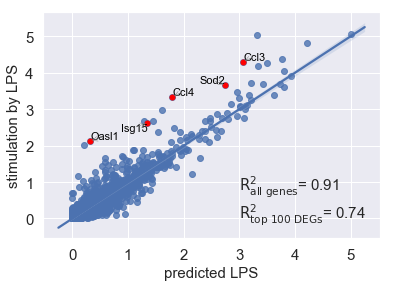

In [21]:
conditions = {"pred_stim": "pred_stim", "real_stim": "real_stim"}
matplotlib.rc('ytick', labelsize=16)
matplotlib.rc('xtick', labelsize=16)
scgen.plotting.reg_mean_plot(all_Data, 
                             condition_key="condition",
                             axis_keys={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                             gene_list=gene_list[:5],
                             top_100_genes=gene_list,
                             path_to_save=os.path.join(path_to_save, f"Fig5b_study_reg_mean_all_genes.pdf"),
                             legend=False,
                             title="",
                             fontsize=15,
                             labels={"x":"predicted LPS", "y":"stimulation by LPS"},
                             show=True, 
                             x_coeff=0.40,
                             y_coeff=0.85,
                             range=[0, 7, 1])

In [22]:
all_Data.obs['condition'].value_counts()

real_stim    9423
ctrl         8421
pred_stim    7428
Name: condition, dtype: int64

### Figure 5.c

In [23]:
all_stim = sc.AnnData(np.concatenate([rat_stim.X.A, pred_rat1 ,rat_cd.X.A, rabbit_cd.X.A,
                                      rabbit_stim.X.A, pig_cd.X.A, pig_stim.X.A, mouse_cd.X.A,
                                      mouse_stim.X.A]))
all_stim.var_names = train.var_names
all_stim.obs["condition"] = ["rat_LPS6"] * len(rat_stim) + ["rat_LPS6_pred"] * len(pred_rat1) + ["rat_ctrl"]*len(rat_cd) + ["rabbit_ctrl"]*len(rabbit_cd)  + ["rabbit_LPS6"] *len(rabbit_stim)\
+ ["pig_ctrl"]*len(pig_cd) + ["pig_LPS6"]*len(pig_stim) + ["mouse_ctrl"]*len(mouse_cd)\
+ ["mouse_LPS6"]*len(mouse_stim)

... storing 'condition' as categorical


saving figure to file ../results/Figures/Figure 5/dotplot_cross_species.pdf


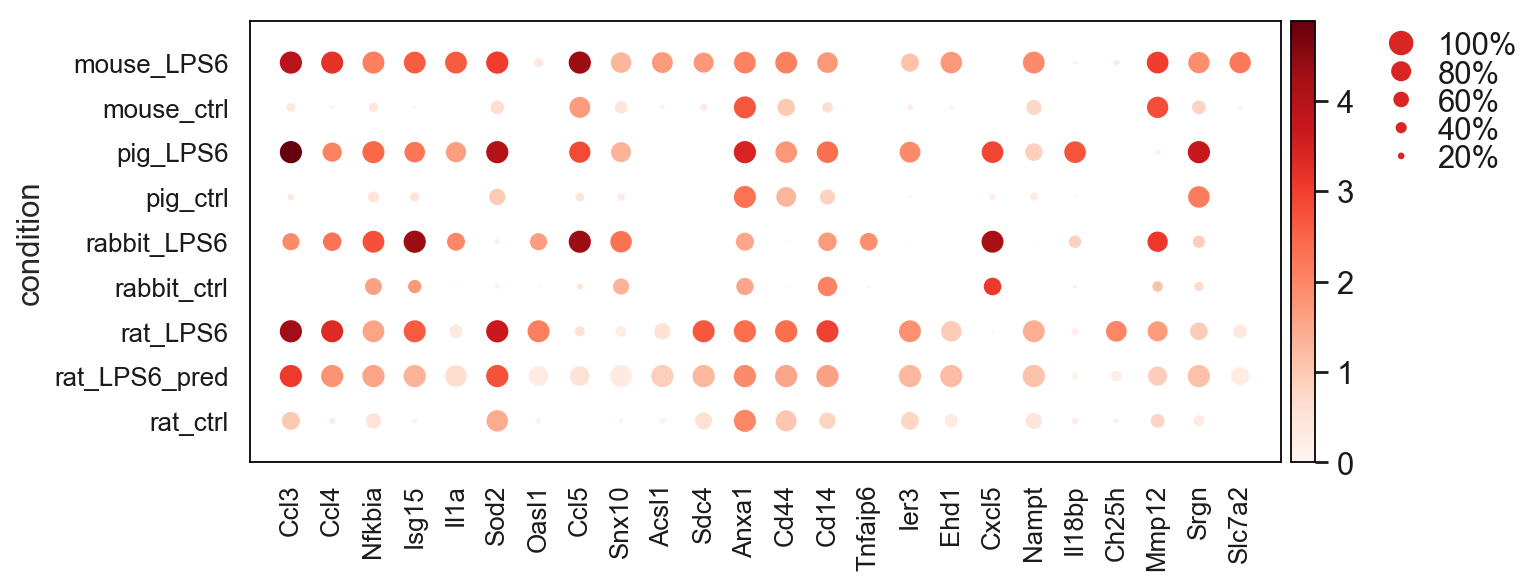

In [19]:
sc.set_figure_params(fontsize=14)
sc.pl.dotplot(all_stim, groupby="condition", var_names=gene_list_dot,
              save=f"_cross_species.pdf", use_raw=False)
os.rename(src=os.path.join(path_to_save, "dotplot_cross_species.pdf"), 
          dst=os.path.join(path_to_save, "Fig5c_dotplot_cross_species.pdf"))

In [24]:
all_stim.obs['condition'].value_counts()

rat_LPS6         9423
rabbit_ctrl      8856
pig_ctrl         8448
rat_ctrl         8421
mouse_ctrl       7625
mouse_LPS6       7428
rat_LPS6_pred    7428
rabbit_LPS6      7107
pig_LPS6         4806
Name: condition, dtype: int64